<a href="https://colab.research.google.com/github/Maagnitude/coupon-recommend-models/blob/main/coupon_recommend_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In-vehicle Coupon Recommendation Models**
Importing the necessary libraries.

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import model_selection
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## **Uploading the dataset as a csv file**

Ανεβάζουμε το dataset μέσω του **github url**, απ το **repository**. Έτσι γλιτώνουμε το mount του drive.

In [2]:
url = "https://raw.githubusercontent.com/Maagnitude/coupon_recommend_models/main/in-vehicle-coupon-recommendation.csv"
df = pd.read_csv(url)
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## **Another way to load the dataset (Drive mount)**

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive
# drive.mount('/content/drive/')
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/in-vehicle-coupon-recommendation.csv')

## **Here we see the shape of the dataframe**. 

We have a **12684 x 26** table. 12684 entries, 26 attributes.

In [ ]:
df.shape

(12684, 26)

In [3]:
sec_df = df.copy()

With the use of **df.info()**, we can see that there are some missing. Car has only 108 non-null values, out of 12684. So we will drop this attribute for sure.We can also see clearly the attributes with null values, using **df.isnull().sum()**.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [4]:
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [5]:
df= df.drop("car", axis='columns')

Here we check the value counts for each categorical value. It seems like a good strategy for each **null-value** to get the value of the **most frequent**.

In [ ]:
df['Bar'].value_counts()

never    5197
less1    3482
1~3      2473
4~8      1076
gt8       349
Name: Bar, dtype: int64

In [ ]:
df['CoffeeHouse'].value_counts()

less1    3385
1~3      3225
never    2962
4~8      1784
gt8      1111
Name: CoffeeHouse, dtype: int64

In [ ]:
df['CarryAway'].value_counts()

1~3      4672
4~8      4258
less1    1856
gt8      1594
never     153
Name: CarryAway, dtype: int64

In [ ]:
df['RestaurantLessThan20'].value_counts()

1~3      5376
4~8      3580
less1    2093
gt8      1285
never     220
Name: RestaurantLessThan20, dtype: int64

In [6]:
df['Restaurant20To50'].value_counts()

less1    6077
1~3      3290
never    2136
4~8       728
gt8       264
Name: Restaurant20To50, dtype: int64

# **Impute NaN values**
Done by using the most frequent of the existing values.

In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Bar'] = imputer.fit_transform(df['Bar'].values.reshape(-1,1))[:,0]

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['CoffeeHouse'] = imputer.fit_transform(df['CoffeeHouse'].values.reshape(-1,1))[:,0]

In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['CarryAway'] = imputer.fit_transform(df['CarryAway'].values.reshape(-1,1))[:,0]

In [10]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['RestaurantLessThan20'] = imputer.fit_transform(df['RestaurantLessThan20'].values.reshape(-1,1))[:,0]

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Restaurant20To50'] = imputer.fit_transform(df['Restaurant20To50'].values.reshape(-1,1))[:,0]

In [12]:
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


Now, as we see, there is no null-value in our dataframe.

In [13]:
df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

# **ONE-HOT ENCODING**

Here we can see the data type of each attribute. Temperature has only **three** numerical values, so we will cast it as **categorical** in order to one-hot encode it later.

In [14]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

In [19]:
df['temperature'].value_counts()

80    6528
55    3840
30    2316
Name: temperature, dtype: int64

In [15]:
df['temperature']=pd.Categorical(df.temperature)

In [ ]:
df

Numerical-value attributes are already in one-hot encoded form (0s and 1s), so we won't mess with them. 

In [18]:
df['occupation'].value_counts()

Unemployed                                   1870
Student                                      1584
Computer & Mathematical                      1408
Sales & Related                              1093
Education&Training&Library                    943
Management                                    838
Office & Administrative Support               639
Arts Design Entertainment Sports & Media      629
Business & Financial                          544
Retired                                       495
Food Preparation & Serving Related            298
Healthcare Practitioners & Technical          244
Healthcare Support                            242
Community & Social Services                   241
Legal                                         219
Transportation & Material Moving              218
Architecture & Engineering                    175
Personal Care & Service                       175
Protective Service                            175
Life Physical Social Science                  170


In [22]:
df.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y'],
      dtype='object')

In [20]:
df_categorical=df.select_dtypes(exclude='number')

In [23]:
df_categorical

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3


In [24]:
for value in df_categorical:
  df= pd.get_dummies(df,columns=[value])

In [25]:
df

,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,destination_Home,destination_No Urgent Place,destination_Work,...,RestaurantLessThan20_1~3,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1~3,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,1,1,0,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,1,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,1,1,1,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3,1,1,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,1,1,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,1,0,0,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
12680,0,1,0,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
12681,0,1,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
12682,0,1,1,1,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [26]:
df.shape

(12684, 112)

## **Dropping Duplicate Values**

In [27]:
df.drop_duplicates(inplace=True)
df.shape

(12610, 112)

We can see that 'toCoupon_GEQ5min' gets only one value. So we don't need that. 

In [28]:
df.select_dtypes('int64').nunique()

has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

In [29]:
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

## direction_opp has opposite values from direction_same

In [30]:
df.drop(columns=['direction_opp'], inplace=True)

In [31]:
df.describe()

,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),...,RestaurantLessThan20_1~3,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1~3,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
count,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,...,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000,12610.000000
mean,0.414512,0.559794,0.116019,0.215543,0.567565,0.256146,0.496907,0.246947,0.574782,0.261063,...,0.434972,0.281761,0.101665,0.164235,0.017367,0.259001,0.057732,0.020936,0.494052,0.168279
std,0.492657,0.496432,0.320260,0.411215,0.495434,0.436521,0.500010,0.431253,0.494396,0.439231,...,0.495773,0.449875,0.302220,0.370503,0.130640,0.438103,0.233245,0.143175,0.499984,0.374129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
df.dtypes

has_children              int64
toCoupon_GEQ15min         int64
toCoupon_GEQ25min         int64
direction_same            int64
Y                         int64
                          ...  
Restaurant20To50_1~3      uint8
Restaurant20To50_4~8      uint8
Restaurant20To50_gt8      uint8
Restaurant20To50_less1    uint8
Restaurant20To50_never    uint8
Length: 110, dtype: object

In [34]:
cluster_df = df.copy()

#**Classification (Logistic Regression)**

In [35]:
X = df.drop('Y', axis=1)

In [36]:
y = df['Y']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [38]:
lr = linear_model.LogisticRegression()
lr_mod = lr.fit(X_train, y_train)

In [48]:
#Predict the response for test dataset
y_pred_Lr = lr_mod.predict(X_test)

log_accuracy = accuracy_score(y_test, y_pred_Lr)

print(f'Accuracy: {log_accuracy:.3f}')

Accuracy: 0.691


# **Classification (KNN Algorithm)**

Με scale μας βγήκε 0.03 λιγότερο.

In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [57]:
classifier = KNeighborsClassifier(n_neighbors = 30, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

In [58]:
y_pred = classifier.predict(X_test)

In [59]:
knn_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {knn_accuracy:.3f}')

Accuracy: 0.712


# **SVM Algorithm**

Αργεί πάρα πολύ η εκπαίδευση του.

In [61]:
SVM = SVC(kernel="rbf", random_state=None, probability=True, cache_size=200, gamma=0.1)
SVM.fit(X_train, y_train)

SVC(gamma=0.1, probability=True)

In [62]:
y_pred_SVM = SVM.predict(X_test)
SVM_accuracy = accuracy_score(y_test, y_pred_SVM)

print(f'Accuracy: {SVM_accuracy:.3f}')

Accuracy: 0.750


# **Decision Tree**

In [63]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_DTC = DTC.predict(X_test)

DTC_accuracy = accuracy_score(y_test, y_pred_DTC)

print(f'Accuracy: {DTC_accuracy:.3f}')

Accuracy: 0.680


# **Random Forest**

In [215]:
randForest =  RandomForestClassifier()
randForest.fit(X_train, y_train)

importances = randForest.feature_importances_

# sort the feature importances
indices = np.argsort(importances)[::-1]

# select the top 5 features
selected_features = indices[:5]

#Predict the response for test dataset
y_pred_randForest = randForest.predict(X_test)

rnf_accuracy = accuracy_score(y_test, y_pred_randForest)

print(f'Accuracy: {rnf_accuracy:.3f}')

Accuracy: 0.750


In [216]:
selected_features = selected_features.tolist()

In [220]:
print(selected_features)

[23, 26, 24, 93, 22]


In [218]:
df_new = df.iloc[:, selected_features]

In [219]:
df_new = pd.concat([df_new, df['Y']], axis=1)

In [221]:
df_new

,coupon_Bar,coupon_Restaurant(20-50),coupon_Carry out & Take away,CoffeeHouse_less1,time_7AM,Y
0,0,0,0,0,0,1
1,0,0,0,0,0,0
2,0,0,1,0,0,1
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
12679,0,0,1,0,0,1
12680,0,0,1,0,1,1
12681,0,0,0,0,1,0
12682,1,0,0,0,1,0


In [222]:
newX = df_new.drop('Y', axis=1)
newy = df_new['Y']
newX_train, newX_test, newy_train, newy_test = train_test_split(newX, newy, train_size=0.7, random_state=42)

In [223]:
randForest =  RandomForestClassifier()
randForest.fit(newX_train, newy_train)

#Predict the response for test dataset
newy_pred_randForest = randForest.predict(newX_test)

new_rnf_accuracy = accuracy_score(newy_test, newy_pred_randForest)

print(f'Accuracy: {new_rnf_accuracy:.3f}')

Accuracy: 0.609


# **Naive Bayes**

In [66]:
bayes =  GaussianNB()
bayes.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_bayes = bayes.predict(X_test)

bayes_accuracy = accuracy_score(y_test, y_pred_bayes)

print(f'Accuracy: {bayes_accuracy:.3f}')


Accuracy: 0.637


In [68]:
def NeuralN(X_train, X_test, y_train, y_test):

  model = keras.Sequential([
      layers.Input(shape=(X_train.shape[1],), name='input'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(3, activation='softmax', name='output')      
  ])

  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
  )
  model.summary()
  history = model.fit(X_train, y_train, epochs=30, batch_size = 128)
  accuracy = model.evaluate(X_test, y_test)

  y_test_c = tf.keras.utils.to_categorical(y_test)

  y_pred = model.predict(X_test)
  pred_idx = np.argmax(y_pred, axis=1)
  true_idx = np.argmax(y_test_c, axis=1)
  tf_confmatrix = tf.math.confusion_matrix(true_idx, pred_idx)

  return accuracy, tf_confmatrix

In [70]:
nn_accuracy, tf_confmatrix = NeuralN(X_train, X_test, y_train, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               11000     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 output (Dense)              (None, 3)                 303       
                                                                 
Total params: 41,603
Trainable params: 41,603
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
69/69 [==============================] 

In [73]:
print(f'Accuracy: {nn_accuracy[1]:.3f}')

Accuracy: 0.732


In [74]:
def heat_confmatrix (confmatrix):
  
  labels = ['Accept', 'NotAccept']

  # Δίνουμε τα labels στον πίνακα
  conf_matr_plt = pd.DataFrame(confmatrix, index = labels, columns = labels)
  
  plt.subplots(figsize=(7, 5))
  
  ax = sns.heatmap(conf_matr_plt, cmap='viridis', annot=True, annot_kws={'size':20}, fmt="d")

  ax.xaxis.tick_top()
  ax.set_title("Confusion Matrix\n")
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

In [75]:
tf_confmatrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1122,  532],
       [ 481, 1648]], dtype=int32)>

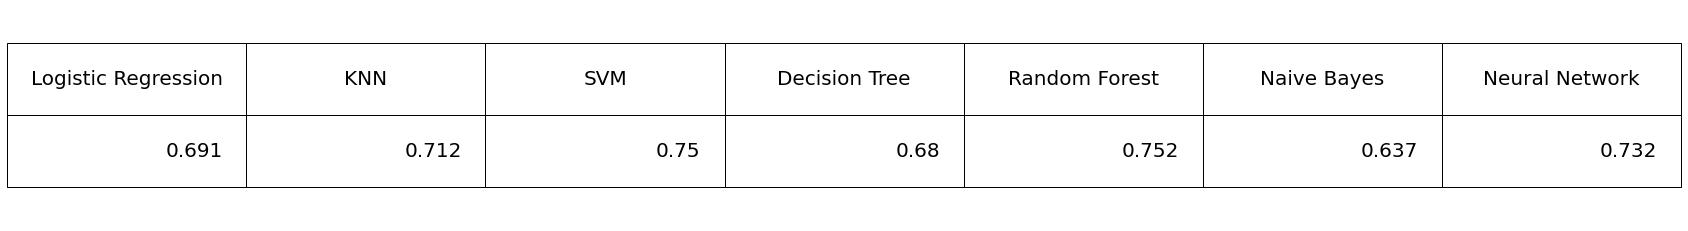

In [99]:
labels = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree',
          'Random Forest', 'Naive Bayes', 'Neural Network']

data = [[log_accuracy, knn_accuracy, SVM_accuracy, DTC_accuracy, rnf_accuracy, bayes_accuracy, nn_accuracy[1]]]

data = np.array(data)
data = np.round(data, 3)
fig, ax = plt.subplots()
table = ax.table(cellText=data, colLabels=labels, loc='center')
table.set_fontsize(60)
table.scale(5,6)
ax.axis('off')
ax.grid(False)

plt.show()

# 2) Επιλογή 5 γνωρισμάτων.
Αρχικά σκεφτήκαμε να δούμε τα γνωρίσματα τα οποία βγάζουν περισσότερο νοήμα σε εμας για να αποτελέσουν κριτήριο επιλογής κουπονιού. Ελέγξαμε το sec_df.groupby("")["Y"].mean() του κάθε γνωρίσματος για να δούμε πόσο διαφοροποιούνται οι μέσοι όροι των τιμών τους. Επειδή όμως με αυτό τον τρόπο ελέγχουμε μονομερώς το κάθε γνώρισμα αν παίρνει ή όχι το κουπόνι χωρίς να ελέγχουμε τα υπόλοιπα γνωρίσματα αποφασίσαμε να επιλέξουμε 5 γνωρίσματα σύμφωνα με κάποια δικά μας κριτήρια και να δούμε ποιος συνδιασμός επιτυγχάνει το μεγαλύτερο αποτέλεσμα.

In [91]:
sec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

In [90]:
sec_df.drop(columns=['toCoupon_GEQ5min', 'car', 'direction_opp'], inplace=True)

In [93]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
sec_df['Bar'] = imputer.fit_transform(sec_df['Bar'].values.reshape(-1,1))[:,0]

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
sec_df['CoffeeHouse'] = imputer.fit_transform(sec_df['CoffeeHouse'].values.reshape(-1,1))[:,0]

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
sec_df['CarryAway'] = imputer.fit_transform(sec_df['CarryAway'].values.reshape(-1,1))[:,0]

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
sec_df['RestaurantLessThan20'] = imputer.fit_transform(sec_df['RestaurantLessThan20'].values.reshape(-1,1))[:,0]

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
sec_df['Restaurant20To50'] = imputer.fit_transform(sec_df['Restaurant20To50'].values.reshape(-1,1))[:,0]

In [96]:
sec_df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
dtype: int64

In [100]:
secX = sec_df.drop('Y', axis=1)
secy = sec_df['Y']
secX_train, secX_test, secy_train, secy_test = train_test_split(secX, secy, train_size=0.7, random_state=42)

In [ ]:
df_corr = sec_df.corr()

In [ ]:
sec_df['toCoupon_GEQ5min'].value_counts()

1    12684
Name: toCoupon_GEQ5min, dtype: int64

In [ ]:
df_corr['Y']

temperature          0.061240
has_children        -0.045557
toCoupon_GEQ5min          NaN
toCoupon_GEQ15min   -0.081602
toCoupon_GEQ25min   -0.103633
direction_same       0.014570
direction_opp       -0.014570
Y                    1.000000
Name: Y, dtype: float64

In [ ]:
sec_df.groupby("has_children")["Y"].mean()

has_children
0    0.587404
1    0.541595
Name: Y, dtype: float64

In [ ]:
sec_df["has_children"].value_counts()

0    7431
1    5253
Name: has_children, dtype: int64

In [ ]:
sec_df = sec_df[["destination", "expiration", "education", "income", "toCoupon_GEQ25min", "Y"]]

In [ ]:
sec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   destination        12684 non-null  object
 1   expiration         12684 non-null  object
 2   education          12684 non-null  object
 3   income             12684 non-null  object
 4   toCoupon_GEQ25min  12684 non-null  int64 
 5   Y                  12684 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 594.7+ KB


In [ ]:
sec_df.isnull().sum()

destination          0
expiration           0
education            0
income               0
toCoupon_GEQ25min    0
Y                    0
dtype: int64

No need to impute values for these 5 categories

# One-hot Encoding

In [ ]:
sec_df.dtypes

destination          object
expiration           object
education            object
income               object
toCoupon_GEQ25min     int64
Y                     int64
dtype: object

In [ ]:
sec_df.columns

Index(['destination', 'expiration', 'education', 'income', 'toCoupon_GEQ25min',
       'Y'],
      dtype='object')

In [ ]:
secdf_categorical=sec_df.select_dtypes(exclude='number')
secdf_categorical

,destination,expiration,education,income
0,No Urgent Place,1d,Some college - no degree,$37500 - $49999
1,No Urgent Place,2h,Some college - no degree,$37500 - $49999
2,No Urgent Place,2h,Some college - no degree,$37500 - $49999
3,No Urgent Place,2h,Some college - no degree,$37500 - $49999
4,No Urgent Place,1d,Some college - no degree,$37500 - $49999
...,...,...,...,...
12679,Home,1d,Bachelors degree,$75000 - $87499
12680,Work,1d,Bachelors degree,$75000 - $87499
12681,Work,1d,Bachelors degree,$75000 - $87499
12682,Work,1d,Bachelors degree,$75000 - $87499


In [ ]:
for value in secdf_categorical:
  sec_df= pd.get_dummies(sec_df,columns=[value])

In [ ]:
sec_df

,toCoupon_GEQ25min,Y,destination_Home,destination_No Urgent Place,destination_Work,expiration_1d,expiration_2h,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),...,education_Some college - no degree,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500
0,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,1,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,0,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
12680,0,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
12681,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
12682,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
sec_df.shape

(12684, 22)

In [ ]:
sec_df.select_dtypes('int64').nunique()

toCoupon_GEQ25min    2
Y                    2
dtype: int64

# Split dataset

In [ ]:
sec_X = sec_df.drop('Y', axis=1)

In [ ]:
sec_y = sec_df['Y']

In [ ]:
SX_train, SX_test, Sy_train, Sy_test = train_test_split(sec_X, sec_y, train_size=0.7, random_state=42)

# Random Forest
best algorithm

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randForest = RandomForestClassifier()

randForest.fit(SX_train, Sy_train)
Saccuracy = randForest.score(SX_test, Sy_test)
print(f'Accuracy: {Saccuracy:.2f}')  

Accuracy: 0.62


# Clustering

In [ ]:
cluster_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0


In [ ]:
cluster_df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

In [ ]:
cluster_df.drop_duplicates(inplace=True)

In [ ]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12610 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12610 non-null  object
 1   passanger             12610 non-null  object
 2   weather               12610 non-null  object
 3   temperature           12610 non-null  int64 
 4   time                  12610 non-null  object
 5   coupon                12610 non-null  object
 6   expiration            12610 non-null  object
 7   gender                12610 non-null  object
 8   age                   12610 non-null  object
 9   maritalStatus         12610 non-null  object
 10  has_children          12610 non-null  int64 
 11  education             12610 non-null  object
 12  occupation            12610 non-null  object
 13  income                12610 non-null  object
 14  Bar                   12610 non-null  object
 15  CoffeeHouse           12610 non-null

## One-hot Encoding in cluster_df

In [ ]:
cluster_df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

In [ ]:
cluster_df.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'direction_opp', 'Y'],
      dtype='object')

In [ ]:
cluster_categorical = cluster_df.select_dtypes(exclude='number')
cluster_categorical

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,Some college - no degree,Unemployed,$37500 - $49999,never,never,1~3,4~8,1~3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,6PM,Carry out & Take away,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12680,Work,Alone,Rainy,7AM,Carry out & Take away,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12681,Work,Alone,Snowy,7AM,Coffee House,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3
12682,Work,Alone,Snowy,7AM,Bar,1d,Male,26,Single,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3


In [ ]:
for value in cluster_categorical:
  cluster_df= pd.get_dummies(cluster_df,columns=[value])

In [ ]:
cluster_df

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,destination_Home,destination_No Urgent Place,...,RestaurantLessThan20_1~3,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_1~3,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,55,1,1,0,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,0
1,80,1,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
2,80,1,1,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,0
3,80,1,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
4,80,1,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,55,0,1,0,0,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
12680,55,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
12681,30,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
12682,30,0,1,1,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [ ]:
cluster_df.select_dtypes('int64').nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

In [ ]:
# cluster_df = cluster_df[["temperature", "has_children"]]

In [ ]:
cluster_df.shape

(12610, 110)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_cluster_df = scaler.fit_transform(cluster_df)

In case you have too many columns, you can use feature selection techniques like PCA(Principal component analysis) to reduce dimensionality of the data. You can also specify the number of components you want to keep. It's important to note that, PCA is an unsupervised technique and it will not take into account the labels of the data but it can be used to reduce the dimensionality of the data and make the clustering process more computationally efficient.

Also, the results of PCA are sensitive to the scaling of the data so it's recommended to use StandardScaler() before applying PCA and k-means.

In [ ]:
from sklearn.decomposition import PCA

# Create a PCA object with the desired number of components
pca = PCA(n_components=2)

# Fit and transform the data using the PCA object
cluster_df_pca = pca.fit_transform(scaled_cluster_df)


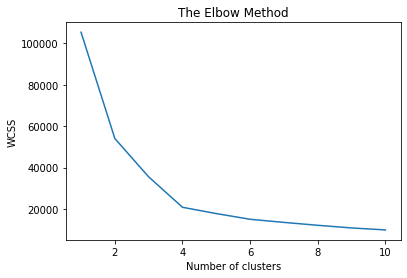

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(cluster_df_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(cluster_df_pca)

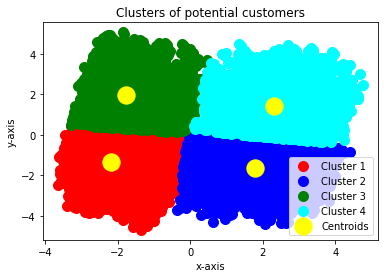

In [ ]:
plt.scatter(cluster_df_pca[y_kmeans == 0, 0], cluster_df_pca[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(cluster_df_pca[y_kmeans == 1, 0], cluster_df_pca[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(cluster_df_pca[y_kmeans == 2, 0], cluster_df_pca[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(cluster_df_pca[y_kmeans == 3, 0], cluster_df_pca[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of potential customers')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Predict the cluster labels for each data point
cluster_labels = kmeans.predict(cluster_df_pca)

# Compute the silhouette score
score = silhouette_score(cluster_df_pca, cluster_labels)

# Print the silhouette score
print("Silhouette score: {:.3f}".format(score))


Silhouette score: 0.478
